In [109]:
import numpy as np
import matplotlib.pyplot as plt
import time

def initial_lattice(N):   
    # generates a random spin configuration for NxN lattice
    return 2*np.random.randint(2, size=(N,N))-1

def Hamiltonian(S, J, B):
    N = len(S[1])
    H = 0
    for i in range(N):
        for j in range(N):
            # Periodic boundary conditions (neighbors: right, down)
            H += -J * S[i][j] * (S[i][(j+1)%N] +  S[(i+1)%N][j]) - B * S[i][j]
    return H

def metropolis_step(S, J, B, beta, step_size_factor):
    N = len(S[1])
    for _ in range(N*N*step_size_factor): 
        i, j = np.random.randint(0, N), np.random.randint(0, N)
        dE = 2 * (J * S[i][j] * (S[i][(j-1)%N] +  S[(i-1)%N][j] + S[i][(j+1)%N] +  S[(i+1)%N][j]) + B * S[i][j])
        if dE < 0 or np.random.rand() < np.exp(-dE * beta):
            S[i, j] *= -1  # Flip spin

def staggered_spin_sum(S):
    res = np.sum(S[::2, ::2])+np.sum(S[1::2, 1::2])-np.sum(S[1::2, ::2])-np.sum(S[::2, 1::2])
    return res

def Monte_carlo_with_Metropolis_for_2D_Ising(size_lattice, J, B, beta, n_thermalization, n_sampling, Metropolis_step_size_factor):
    N = size_lattice
    S = initial_lattice(N)
    energies, sum_S_list, sum_S_staggered_list = [], [], []
    Z = 0
    
    for i in range(n_thermalization):
        metropolis_step(S, J, B, beta, Metropolis_step_size_factor)
        
    for i in range(n_sampling):
        metropolis_step(S, J, B, beta, Metropolis_step_size_factor)
        E = Hamiltonian(S, J, B)
        energies.append(E)
        sum_S_list.append(np.sum(S))
        sum_S_staggered_list.append(staggered_spin_sum(S))
        Z += np.exp(-E/beta)

    return energies, sum_S_list, sum_S_staggered_list, Z


def weight_function(energy, Z, beta):
    return np.exp(-energy/beta) / Z 

def magnetization(energies, sum_S_list, Z, beta):
    S = sum_S_list
    M = 0
    for i in range(len(S)):
        M += weight_function(energies[i], Z, beta) * S[i]
    return M

def staggered_magnetization(energies, sum_S_staggered_list, Z, beta):
    S = sum_S_staggered_list
    M = 0
    for i in range(len(S)):
        M += weight_function(energies[i], Z, beta) * S[i]
    return M

def susceptibility(energies, sum_S_list, Z, beta):
    S = sum_S_list
    M = magnetization(energies, S, Z, beta)
    susc = - M**2
    for i in range(len(S)):
        susc += weight_function(energies[i], Z, beta) * (S[i])**2 #/beta
    return susc
   
def energy(energies, Z, beta):
    E = 0
    for i in range(len(energies)):
        E += weight_function(energies[i], Z, beta) * energies[i]
    return E 

def specific_heat(energies, sum_S_list, Z, beta):
    S = sum_S_list
    E = energy(energies, Z, beta)
    C_b = - E**2
    for i in range(len(S)):
        C_b += weight_function(energies[i], Z, beta) * (energies[i])**2
    return C_b * beta**2

def forth_order_cumulant(M):
    return 1 - np.sum(M**4) / (3 * np.sum(M**2)**2)

# do it several times and average again
def average_MCS(N, number_of_fresh_starts, J, B, T, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor):
    num = number_of_fresh_starts
    beta = 1/(k_B * T) 

    order_average = 0
    staggered_order_average = 0

    susc_average = 0
    spec_heat_average = 0
    M_list = []
    staggered_M_list = []
    for i in range(num):
        energies, sum_S_list, sum_S_staggered_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(N, J, B, beta, n_thermalization, n_sampling, Metropolis_step_size_factor)
        M = magnetization(energies, sum_S_list, Z, beta)
        M_list.append(M)
        staggered_M = staggered_magnetization(energies, sum_S_staggered_list, Z, beta)
        staggered_M_list.append(staggered_M)
        order_average += 1/num * np.abs(M)
        staggered_order_average += 1/num * abs(staggered_M)
        susc_average += 1/num * susceptibility(energies, sum_S_list, Z, beta)
        spec_heat_average += 1/num * specific_heat(energies, sum_S_list, Z, beta)

    cumulant = forth_order_cumulant(np.array(M_list))
  
    return order_average, staggered_order_average, susc_average, spec_heat_average, cumulant


def average_MCS2(N, number_of_fresh_starts, J, B, T, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor):
    num = number_of_fresh_starts
    beta = 1/(k_B * T) 

    order_average = 0
    staggered_order_average = 0

    susc_average = 0
    spec_heat_average = 0
    susc_list = []
    specific_heat_list = []
    M_list = []
    staggered_M_list = []
    for i in range(num):
        energies, sum_S_list, sum_S_staggered_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(N, J, B, beta, n_thermalization, n_sampling, Metropolis_step_size_factor)
        M = magnetization(energies, sum_S_list, Z, beta)
        M_list.append(M)
        staggered_M = staggered_magnetization(energies, sum_S_staggered_list, Z, beta)
        staggered_M_list.append(staggered_M)
        # order_average += 1/num * np.abs(M)
        # staggered_order_average += 1/num * abs(staggered_M)
        # susc_average += 1/num * susceptibility(energies, sum_S_list, Z, beta)
        # spec_heat_average += 1/num * specific_heat(energies, sum_S_list, Z, beta)
        susc_list.append(susceptibility(energies, sum_S_list, Z, beta))
        specific_heat_list.append(specific_heat(energies, sum_S_list, Z, beta)) 

    susc_average = np.mean(susc_list)
    spec_heat_average = np.mean(specific_heat_list)
    order_average = np.mean(abs(np.array(M_list)))
    staggered_order_average = np.mean(abs(np.array(staggered_M_list)))


    cumulant = forth_order_cumulant(np.array(M_list))
    
    susc_std = np.std(susc_list)/np.sqrt(len(susc_list))
    spec_heat_std = np.std(specific_heat_list)/np.sqrt(len(specific_heat_list))
    order_std = np.std(abs(np.array(M_list)))/np.sqrt(len(M_list))
    staggered_order_std = np.std(abs(np.array(staggered_M_list)))/np.sqrt(len(staggered_M_list))

    return order_average, staggered_order_average, susc_average, spec_heat_average, cumulant, order_std, staggered_order_std, susc_std, spec_heat_std


def bode(f, a, b, N):
    if not N % 4 == 0:
        raise ValueError("Number of subintervals (n) must be a multiple of 4.")
    
    h = (b-a)/N
    v = np.ones(N+1)*32
    v[4:N:4] = 14
    v[2:N:4] = 12
    v[0] = 7
    v[N] = 7
    w = f(np.linspace(a,b,N+1))
    return 2*h/45*np.dot(v,w)

def energy_exact(J, N_S, kappa, kappa_prime, n):
    return -N_S * J * 1/np.tanh(2*J) * (1 + 2/np.pi * kappa_prime * bode(lambda x: K1_func(kappa, x), 0, np.pi/2, n))

def K1_func(kappa, x):
    return 1/np.sqrt(1 - kappa**2 * np.sin(x)**2)

def E1_func(kappa, x):
    return np.sqrt(1 - kappa**2 * np.sin(x)**2)

def abs_magnetization_exact(J, N_S, J_critical):
    if np.abs(J) >= J_critical:
        z = np.exp(-2*J)
        m = N_S * ((1 + z**2)**(1/4) * (1 - 6*z**2 + z**4))**(1/8) / np.sqrt(1 - z**2)
    else:
        m = 0
    return m

def specific_heat_exact(J, N_S, n=120):
    kappa = 2 * np.sinh(2*J)/(np.cosh(2*J)**2)
    kappa_prime = 2 * np.tanh(2*J)**2 - 1
    K1 = bode(lambda x: K1_func(kappa, x), 0, np.pi/2, n)
    E1 = bode(lambda x: E1_func(kappa, x), 0, np.pi/2, n)
    return N_S * 2/np.pi * (J*1/np.tanh(2*J))**2 * (2*K1 - 2*E1 - (1-kappa_prime) * (np.pi/2 + kappa_prime * K1))

def critical_temperature(J, k_B):
    return 2 * J / (k_B * np.log(1+np.sqrt(2)))

In [136]:
import os
import pandas as pd

def create_unique_folder(base_path, folder_name):
    full_path = os.path.join(base_path, folder_name)
    counter = 1

    while os.path.exists(full_path):
        full_path = os.path.join(base_path, f"{folder_name}_{counter}")
        counter += 1

    os.makedirs(full_path)
    return full_path

def savedata(N_arr, T_arr, J, B, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor, number_of_fresh_starts):
    foldername = f"J{J}_B{B}_nTherm{n_thermalization}_nSamp{n_sampling}_Metropolis{Metropolis_step_size_factor}_freshStarts{number_of_fresh_starts}".replace(".", "p")
    folderpath = create_unique_folder("","data/"+foldername)

    for n in N_arr:
        order_list, staggered_order_list, susc_list, spec_heat_list, cumulant_list, order_std_list, staggered_order_std_list, susc_std_list, spec_heat_std_list = [], [], [], [], [], [], [], [], []
        for T in T_arr:
            order_average, staggered_order_average, susc_average, spec_heat_average, cumulant, order_std, staggered_order_std, susc_std, spec_heat_std = average_MCS2(n, number_of_fresh_starts, J, B, T, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor) 
            order_list.append(order_average)
            staggered_order_list.append(staggered_order_average)
            susc_list.append(susc_average)
            spec_heat_list.append(spec_heat_average)
            cumulant_list.append(cumulant)
            staggered_order_list.append(staggered_order_average) 
            order_std_list.append(order_std)
            susc_std_list.append(susc_std)
            spec_heat_std_list.append(spec_heat_std)
            staggered_order_std_list.append(staggered_order_std) 

        df = pd.DataFrame({"order": order_list/(n**2), "staggered_order": staggered_order_list/(n**2), "susceptibility":susc_list/(n**2), "specific_heat": spec_heat_list/(n**2), "cumulant_list": cumulant_list, "T": T_arr, "order_std": order_std_list/(n**2), "staggered_order_std": staggered_order_std_list/(n**2), "susceptibility_std":susc_std_list/(n**2), "specific_heat_std": spec_heat_std_list/(n**2), "J": J, "B":B, "k_B":k_B})
        df.to_csv(folderpath+f'/res_N_{n}.csv', index=False)


    

In [137]:
colors = ['gold', 'darkorange', 'red']
          
def create_plots(N_arr, T_arr, J, B, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor, number_of_fresh_starts):
    """
    added functionality to additionally save the data
    """
    
    foldername = f"J{J}_B{B}_nTherm{n_thermalization}_nSamp{n_sampling}_Metropolis{Metropolis_step_size_factor}_freshStarts{number_of_fresh_starts}".replace(".", "p")
    folderpath = create_unique_folder("","data/"+foldername)

    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()
    fig5, ax5 = plt.subplots()

    i = 0
    for n in N_arr:
        order_list, staggered_order_list, susc_list, spec_heat_list, cumulant_list, order_std_list, staggered_order_std_list, susc_std_list, spec_heat_std_list = [], [], [], [], [], [], [], [], []
        for T in T_arr:
            order_average, staggered_order_average, susc_average, spec_heat_average, cumulant,  order_std, staggered_order_std, susc_std, spec_heat_std = average_MCS2(n, number_of_fresh_starts, J, B, T, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor) 
            order_list.append(order_average)
            susc_list.append(susc_average)
            spec_heat_list.append(spec_heat_average)
            cumulant_list.append(cumulant) 
            staggered_order_list.append(staggered_order_average) 
            order_std_list.append(order_std)
            susc_std_list.append(susc_std)
            spec_heat_std_list.append(spec_heat_std)
            staggered_order_std_list.append(staggered_order_std) 
     
        ax1.plot(T_arr * k_B / np.abs(J), order_list/(n**2), label=f'L={n}', c = colors[i])
        ax2.plot(T_arr * k_B / np.abs(J), susc_list/(n**2), label=f'L={n}', c = colors[i])
        ax3.plot(T_arr * k_B / np.abs(J), spec_heat_list/(n**2), label=f'L={n}', c = colors[i])
        ax4.plot(T_arr * k_B / np.abs(J), cumulant_list, label=f'L={n}', c = colors[i])
        ax5.plot(T_arr * k_B / np.abs(J), staggered_order_list/(n**2), label=f'L={n}', c = colors[i])
        
        df = pd.DataFrame({"order": order_list/(n**2), "staggered_order": staggered_order_list/(n**2), "susceptibility":susc_list/(n**2), "specific_heat": spec_heat_list/(n**2), "cumulant_list": cumulant_list, "T": T_arr, "order_std": order_std_list/(n**2), "staggered_order_std": staggered_order_std_list/(n**2), "susceptibility_std":susc_std_list/(n**2), "specific_heat_std": spec_heat_std_list/(n**2), "J": J, "B":B, "k_B":k_B})
        df.to_csv(folderpath+f'/res_N_{n}.csv', index=False)

        i += 1

    if B == 0: 
        order_exact = [abs_magnetization_exact(J/(k_B * T), 1, J/(k_B * critical_temperature(J, k_B))) for T in T_arr]
        ax1.plot(T_arr * k_B / np.abs(J), order_exact, ls = '--', label='analytic expression', c = 'black')
        spec_heat_exact = [specific_heat_exact(J/(k_B * T), 1) for T in T_arr]
        ax3.plot(T_arr * k_B / np.abs(J), spec_heat_exact,  ls = '--', label='analytic expression', c = 'black')

        ax1.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
        ax2.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
        ax3.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
        ax4.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
        ax5.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')

    # Magnetization plot
    ax1.set_xlabel(r'$k_B$ T / J')
    ax1.set_ylabel('Magnetization per Spin')
    ax1.legend()

    # Susceptibility plot
    ax2.set_xlabel(r'$k_B$ T / J')
    ax2.set_ylabel('Susceptibility per Spin')
    ax2.legend()

    # Specific Heat plot
    ax3.set_xlabel(r'$k_B$ T / J')
    ax3.set_ylabel('Specific Heat per Spin')
    ax3.legend()

    # Cumulant plot
    ax4.set_xlabel(r'$k_B$ T / J')
    ax4.set_ylabel('4th Order Cumulant')
    ax4.legend()

        # Magnetization plot
    ax5.set_xlabel(r'$k_B$ T / J')
    ax5.set_ylabel('Staggerd Magnetization per Spin')
    ax5.legend()

    # Save plots as PDFs 
    filename_suffix = f"J{J}_B{B}_nTherm{n_thermalization}_nSamp{n_sampling}_Metropolis{Metropolis_step_size_factor}_freshStarts{number_of_fresh_starts}"
    fig1.savefig(f"magnetization_{filename_suffix}.pdf")
    fig2.savefig(f"susceptibility_{filename_suffix}.pdf")
    fig3.savefig(f"specific_heat_{filename_suffix}.pdf")
    fig4.savefig(f"cumulant_{filename_suffix}.pdf")
    fig5.savefig(f"staggered_magnetization_{filename_suffix}.pdf")


    plt.show()

In [138]:
N = np.array([8, 16, 32])
k_B = 1.380649e-23
J = 50 * k_B
B = 0
T_array = np.array([50, 75, 90, 100, 105, 110, 113, 115, 120, 125, 135, 150, 175, 200, 300])

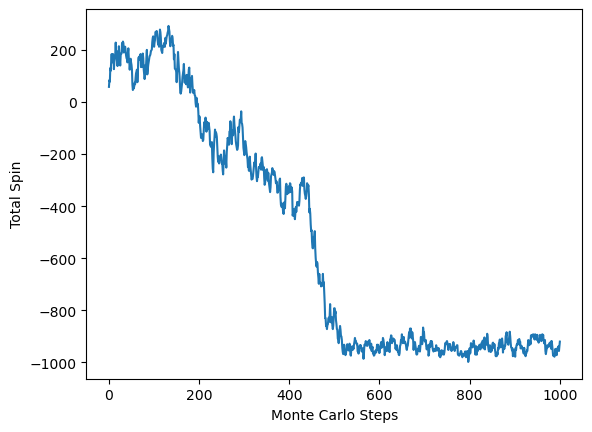

In [139]:
energies, sum_S_list,sum_S_staggered_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(32, 50 * 1.380649e-23, 0, 1/(100 * k_B), 0, 1000, 1)

plt.plot(np.linspace(0,1000,1000), sum_S_list)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.show()

#--> n_thermalization = 900

0     0.999219
1     0.985844
2     0.953469
3     0.820219
4     0.583781
5     0.543750
6     0.356500
7     0.295312
8     0.162656
9     0.121437
10    0.062062
11    0.032312
12    0.030750
13    0.031531
14    0.019281
Name: order_std, dtype: float64

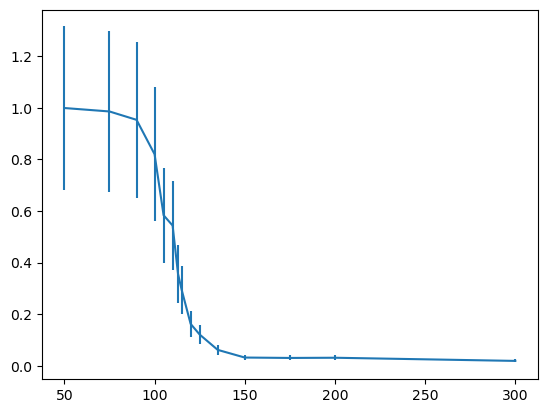

In [140]:
df = pd.read_csv("data/J6p903245000000001e-22_B0_nTherm400_nSamp100_Metropolis20_freshStarts10/res_N_8.csv")

plt.errorbar(df["T"],df["order"], yerr=df["order_std"]/np.sqrt(10))

df["order"]

df["order_std"]

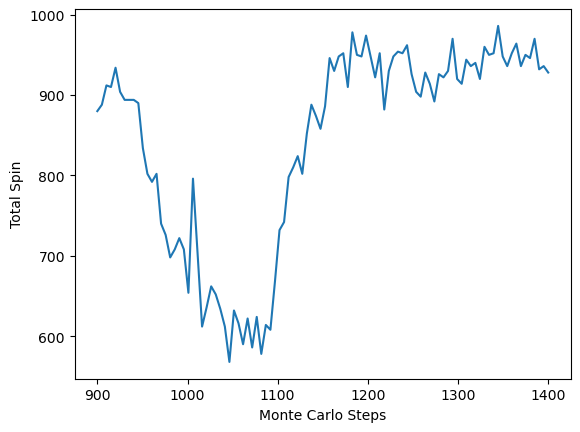

In [141]:
energies, sum_S_list, sum_S_staggered_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(32, 50 * 1.380649e-23, 0, 1/(100* k_B), 180, 100, 5)

plt.plot(np.linspace(900,1400,100), sum_S_list)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.show()

#--> step_size_factor = 5 --> n_thermalization = 900/5 = 180

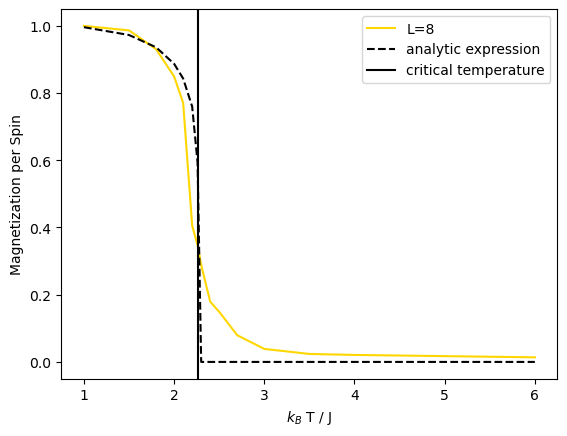

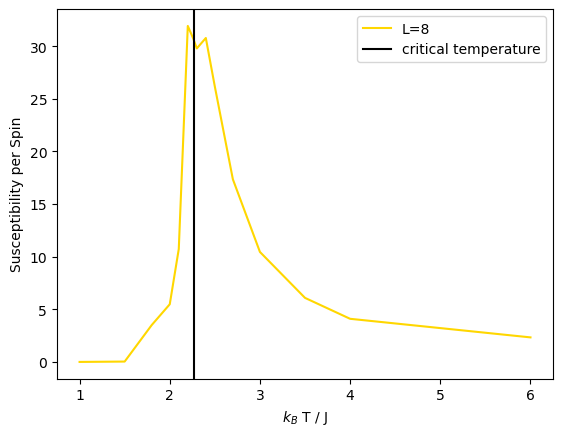

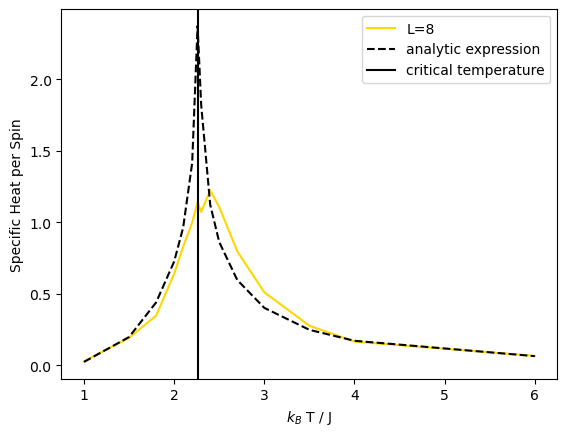

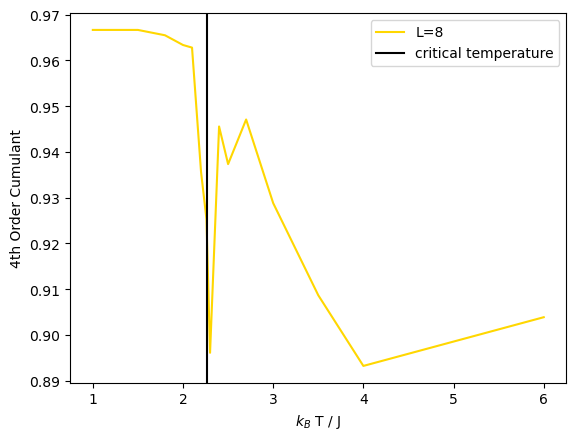

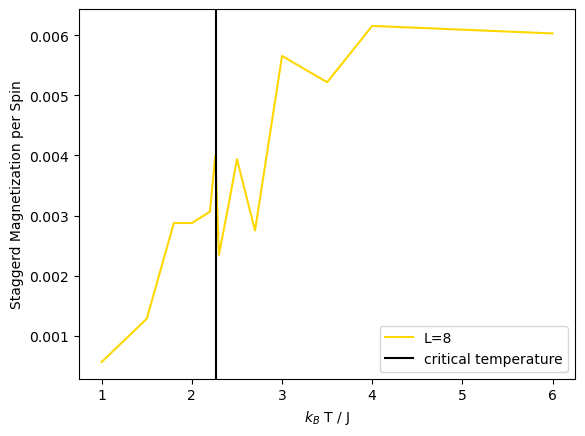

In [142]:
# N_arr, T_arr, J, B, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor, number_of_fresh_starts

create_plots(np.array([8]), T_array, J, B, k_B, 400, 100, 20, 10)#20 -> 40 keine Verbesserung #,100,150, 200,300

In [ ]:
create_plots(np.array([8,16,32]), T_array, J, B, k_B, 400, 100, 20, 10)#20 -> 40 keine Verbesserung #,100,150, 200,300

In [ ]:
create_plots(np.array([8,16,32]), T_array, -J, B, k_B, 400, 100, 20, 10)#20 -> 40 keine Verbesserung #,100,150, 200,300

In [ ]:
B1 = 30*k_B
create_plots(np.array([8,16,32]), T_array, J, B1, k_B, 400, 100, 20, 10)#20 -> 40 keine Verbesserung #,100,150, 200,300

In [ ]:
B1 = 30*k_B
create_plots(np.array([8,16,32]), T_array, -J, B1, k_B, 400, 100, 20, 10)#20 -> 40 keine Verbesserung #,100,150, 200,300

KeyboardInterrupt: 

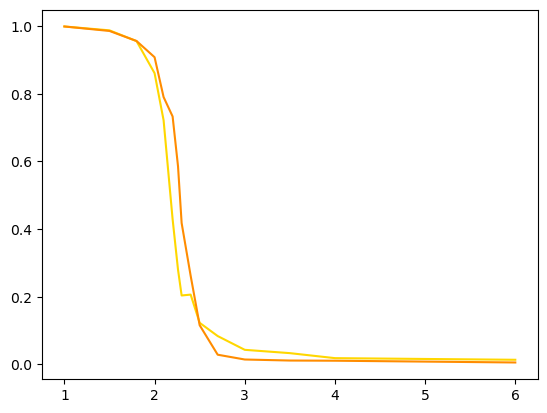

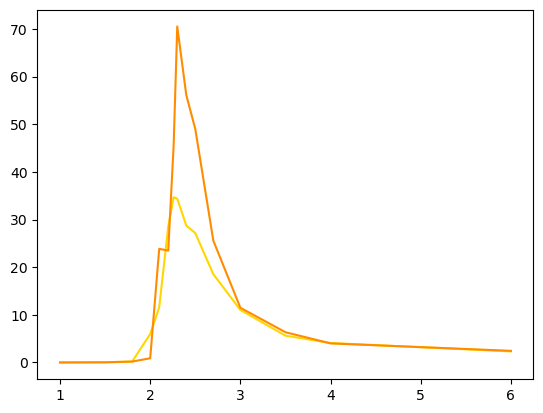

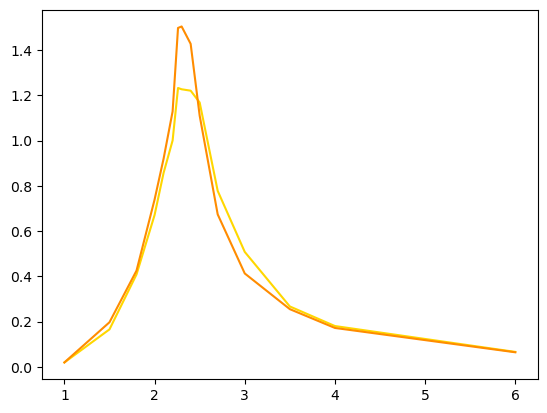

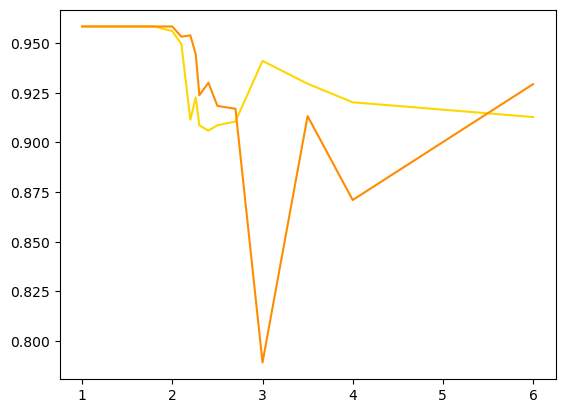

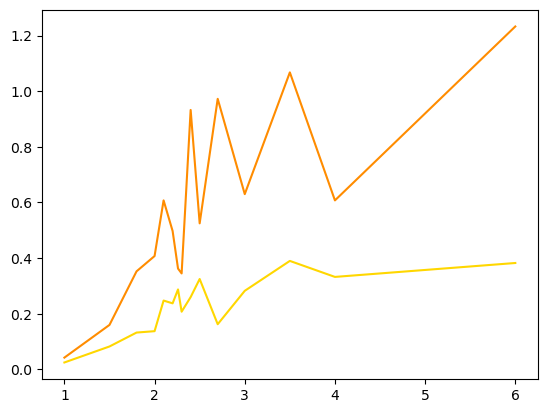

In [72]:
create_plots(N, T_array, J, B, k_B, 180, 100, 20, 8)#20 -> 40 keine Verbesserung

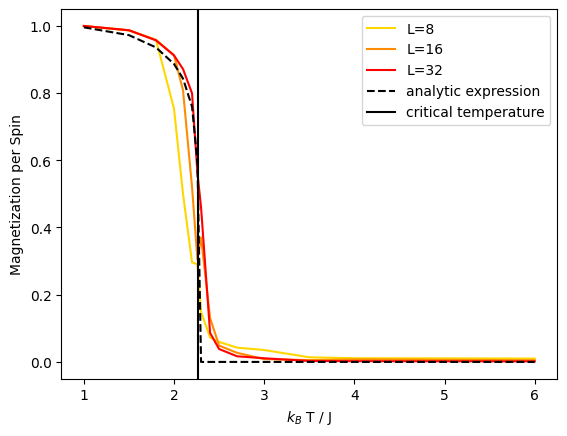

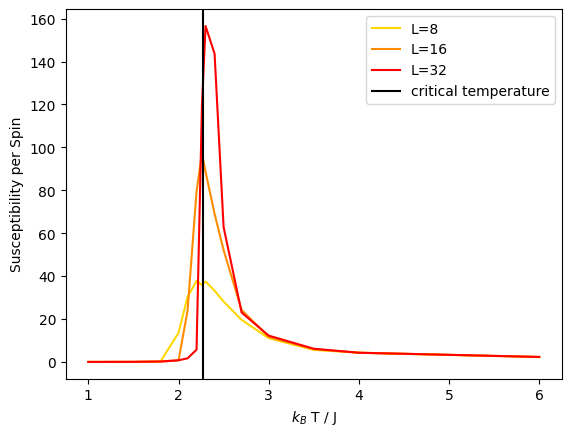

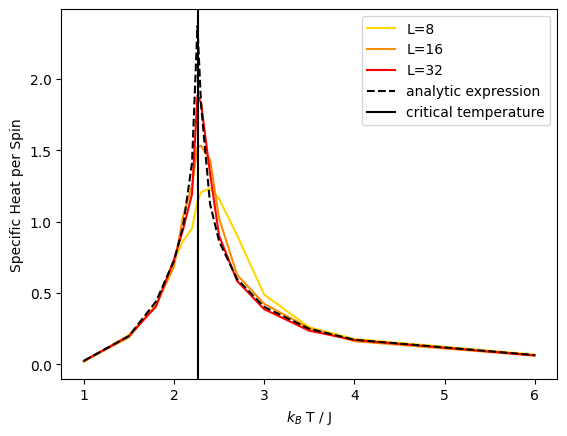

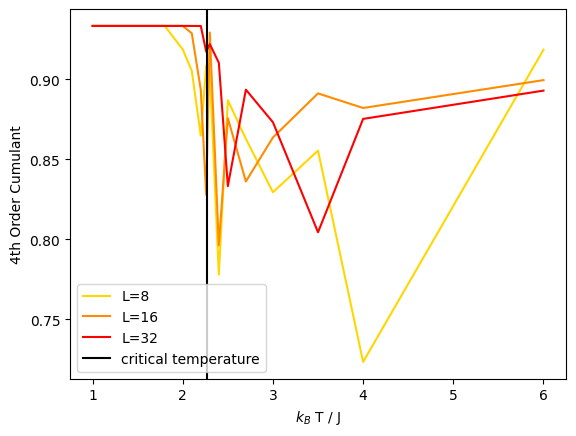

In [ ]:
create_plots(N, T_array, J, B, k_B, 180, 300, 20, 5)

In [ ]:
create_plots(N, T_array, J, B, k_B, 250, 300, 20, 5)

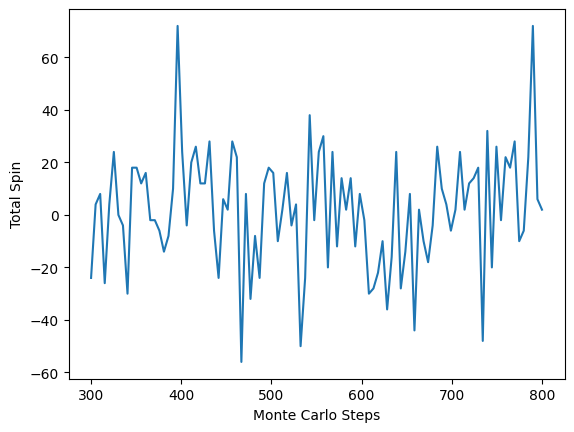

In [ ]:
# antiferromagnetic coupling (J = -50 * k_B & B = 0)

energies, sum_S_list,sum_S_staggered_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(32, -J, 0, 1/(200 * k_B), 60, 100, 5)

plt.plot(np.linspace(300,800,100), sum_S_list)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.show()

In [ ]:
create_plots(N, T_array, -J, B, k_B, 100, 300, 20, 5)

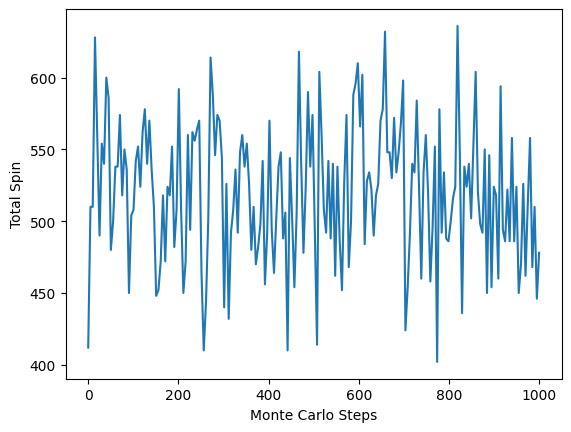

In [ ]:
# non-zero external field B
B1 = 30*k_B

energies, sum_S_list,sum_S_staggered_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(32, J, B1, 1/(200 * k_B), 0, 200, 5)

plt.plot(np.linspace(0,1000,200), sum_S_list)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.show()

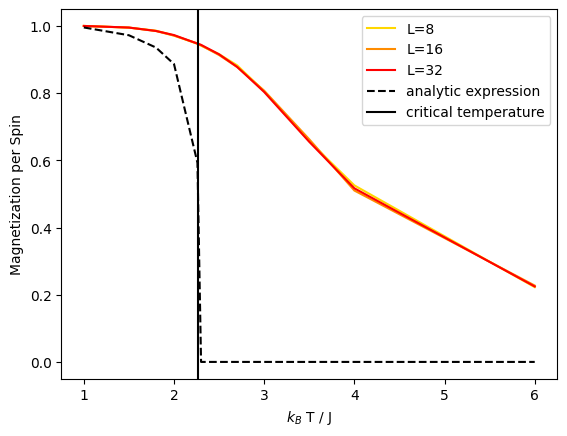

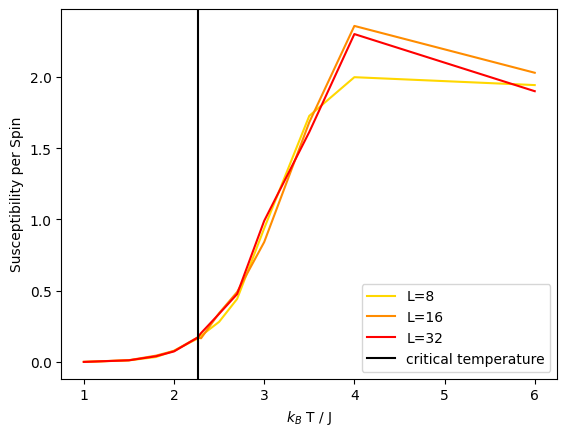

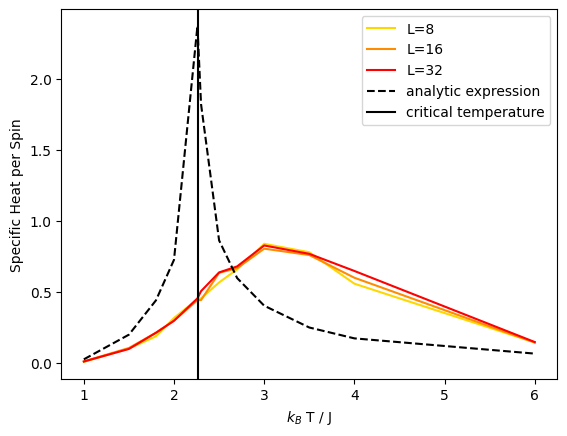

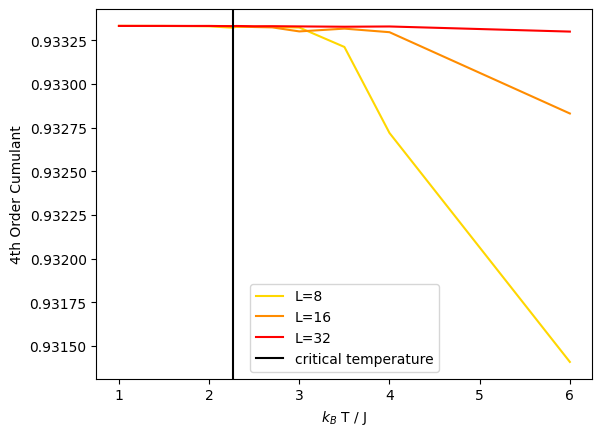

In [ ]:
create_plots(N, T_array, J, B1, k_B, 40, 100, 20, 5)

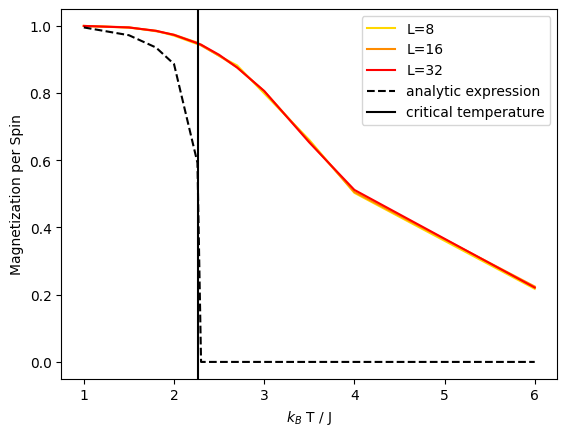

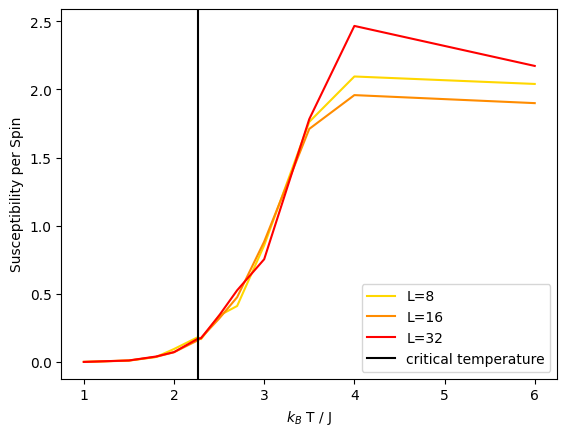

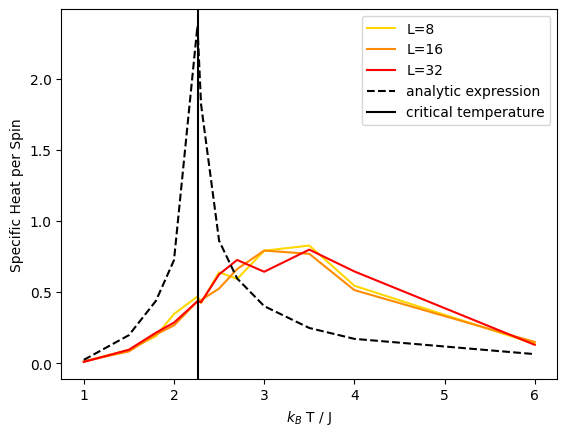

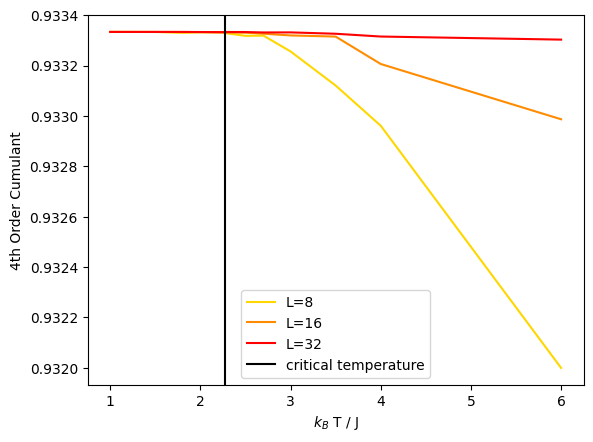

In [ ]:
B2 = -30 *k_B

create_plots(N, T_array, J, B2, k_B, 40, 100, 20, 5)

In [ ]:
#2b

def heat_bath_step(S, J, beta, step_size_factor):
    N = len(S[1])
    for _ in range(N*N*step_size_factor): 
        i, j = np.random.randint(0, N), np.random.randint(0, N)
        neighbors = S[i][(j-1)%N] +  S[(i-1)%N][j] + S[i][(j+1)%N] +  S[(i+1)%N][j]
        prob = np.exp(2*J*beta*neighbors) / (1 + np.exp(2*J*beta*neighbors))
        if np.random.rand() < prob:
            S[i, j] = 1
        else:
            S[i, j] = -1
    

def Monte_carlo_with_heat_bath_for_2D_Ising(size_lattice, J, beta, n_thermalization, n_sampling, step_size_factor):
    N = size_lattice
    S = initial_lattice(N)
    energies, sum_S_list = [], []
    Z = 0
    
    for i in range(n_thermalization):
        heat_bath_step(S, J, beta, step_size_factor)
        
    for i in range(n_sampling):
        heat_bath_step(S, J, beta, step_size_factor)
        E = Hamiltonian(S, J, 0)
        energies.append(E)
        sum_S_list.append(np.sum(S))
        Z += np.exp(-E/beta)

    return energies, sum_S_list, Z


# do it several times and average again
def average_MCS_heat_bath(N, number_of_fresh_starts, J, T, k_B, n_thermalization, n_sampling, step_size_factor):
    num = number_of_fresh_starts
    beta = 1/(k_B * T) 

    order_average = 0
    susc_average = 0
    spec_heat_average = 0
    M_list = []
    for i in range(num):
        energies, sum_S_list, Z = Monte_carlo_with_heat_bath_for_2D_Ising(N, J, beta, n_thermalization, n_sampling, step_size_factor)
        M = magnetization(energies, sum_S_list, Z, beta)
        M_list.append(M)
        order_average += 1/num * np.abs(M)
        susc_average += 1/num * susceptibility(energies, sum_S_list, Z, beta)
        spec_heat_average += 1/num * specific_heat(energies, sum_S_list, Z, beta)

    cumulant = forth_order_cumulant(np.array(M_list))
  
    return order_average, susc_average, spec_heat_average, cumulant


colors = ['gold', 'darkorange', 'red']

def create_plots_heat_bath(N_arr, T_arr, J, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor, number_of_fresh_starts):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()

    i = 0
    for n in N_arr:
        order_list, susc_list, spec_heat_list, cumulant_list = [], [], [], []
        for T in T_arr:
            order_average, susc_average, spec_heat_average, cumulant = average_MCS_heat_bath(n, number_of_fresh_starts, J, T, k_B, n_thermalization, n_sampling, Metropolis_step_size_factor) 
            order_list.append(order_average)
            susc_list.append(susc_average)
            spec_heat_list.append(spec_heat_average)
            cumulant_list.append(cumulant)  
    
        ax1.plot(T_arr * k_B / J, order_list/(n**2), label=f'L={n}', c = colors[i])
        ax2.plot(T_arr * k_B / J, susc_list/(n**2), label=f'L={n}', c = colors[i])
        ax3.plot(T_arr * k_B / J, spec_heat_list/(n**2), label=f'L={n}', c = colors[i])
        ax4.plot(T_arr * k_B / J, cumulant_list, label=f'L={n}', c = colors[i])
        
        i += 1
        
    order_exact = [abs_magnetization_exact(J/(k_B * T), 1, J/(k_B * critical_temperature(J, k_B))) for T in T_arr]
    ax1.plot(T_arr * k_B / J, order_exact, ls = '--', label='analytic expression', c = 'black')
    spec_heat_exact = [specific_heat_exact(J/(k_B * T), 1) for T in T_arr]
    ax3.plot(T_arr * k_B / J, spec_heat_exact,  ls = '--', label='analytic expression', c = 'black')

    # Magnetization plot
    ax1.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
    ax1.set_xlabel(r'$k_B$ T / J')
    ax1.set_ylabel('Magnetization per Spin')
    ax1.legend()

    # Susceptibility plot
    ax2.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
    ax2.set_xlabel(r'$k_B$ T / J')
    ax2.set_ylabel('Susceptibility per Spin')
    ax2.legend()

    # Specific Heat plot
    ax3.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
    ax3.set_xlabel(r'$k_B$ T / J')
    ax3.set_ylabel('Specific Heat per Spin')
    ax3.legend()

    # Cumulant plot
    ax4.axvline(x=critical_temperature(J, k_B) * k_B / J, color='black', label='critical temperature')
    ax4.set_xlabel(r'$k_B$ T / J')
    ax4.set_ylabel('4th Order Cumulant')
    ax4.legend()

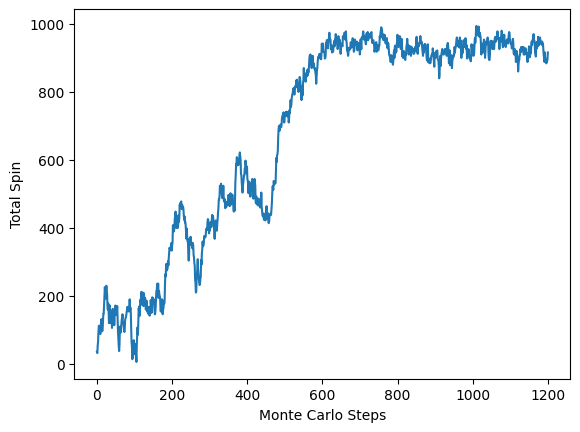

In [ ]:
energies, sum_S_list, Z = Monte_carlo_with_heat_bath_for_2D_Ising(32, 50 * 1.380649e-23, 1/(100* k_B), 0, 1200, 1)

plt.plot(np.linspace(0,1200,1200), sum_S_list)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.show()

#--> n_thermalization = 1200

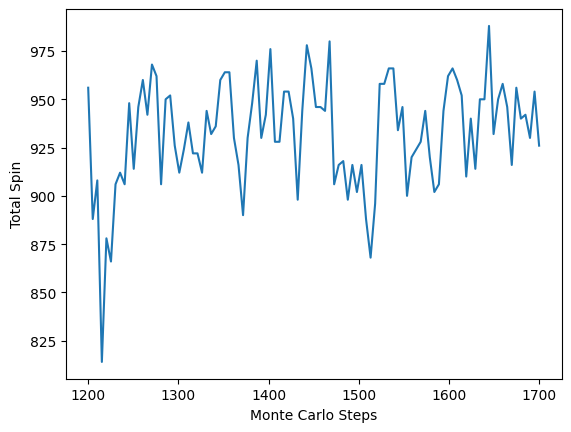

In [ ]:
energies, sum_S_list, Z = Monte_carlo_with_heat_bath_for_2D_Ising(32, 50 * 1.380649e-23, 1/(100* k_B), 240, 100, 5)

plt.plot(np.linspace(1200,1700,100), sum_S_list)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.show()

#--> step_size_factor = 5 --> n_thermalization = 1200/5 = 240

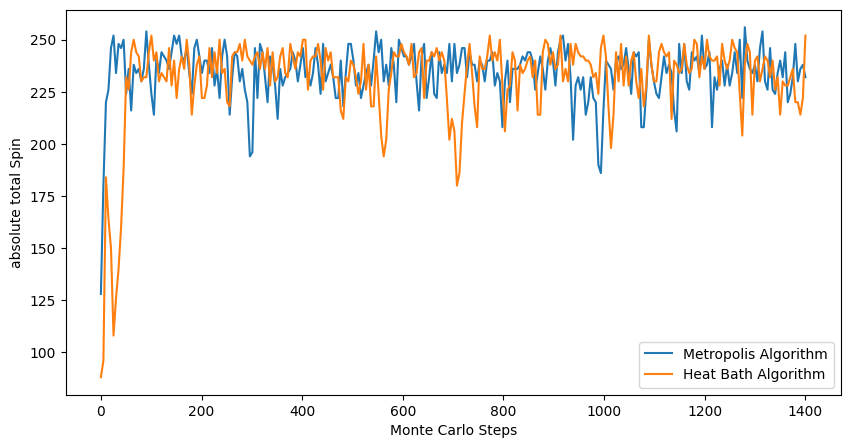

Metropolis algorithm time: 4.12 seconds
Heat Bath algorithm time: 4.81 seconds


In [ ]:
size_lattice = 16
T = 100
beta = 1 / (k_B * T)

n_thermalization = 0 #240
n_meas = 280 #40
step_factor = 5

# Metropolis algorithm
start_time = time.time()
energies_metro, sum_S_list_metro, sum_S_staggered_list, Z_metro = Monte_carlo_with_Metropolis_for_2D_Ising(size_lattice, J, B, beta, n_thermalization, n_meas, step_factor)
metropolis_time = time.time() - start_time

# Heat Bath algorithm
start_time = time.time()
energies_heat_bath, sum_S_list_heat_bath, Z_heat_bath = Monte_carlo_with_heat_bath_for_2D_Ising(size_lattice, J, beta, n_thermalization, n_meas, step_factor)
heat_bath_time = time.time() - start_time

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(n_thermalization,n_thermalization+n_meas,n_meas)*step_factor, np.abs(sum_S_list_metro), label='Metropolis Algorithm')
plt.plot(np.linspace(n_thermalization,n_thermalization+n_meas,n_meas)*step_factor, np.abs(sum_S_list_heat_bath), label='Heat Bath Algorithm')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('absolute total Spin')
plt.legend()
plt.show()

print(f"Metropolis algorithm time: {metropolis_time:.2f} seconds")
print(f"Heat Bath algorithm time: {heat_bath_time:.2f} seconds")

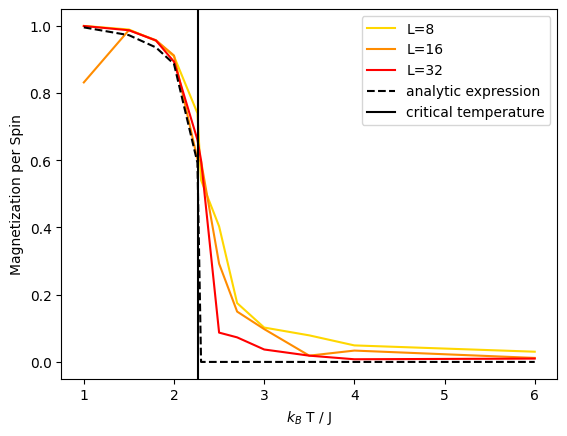

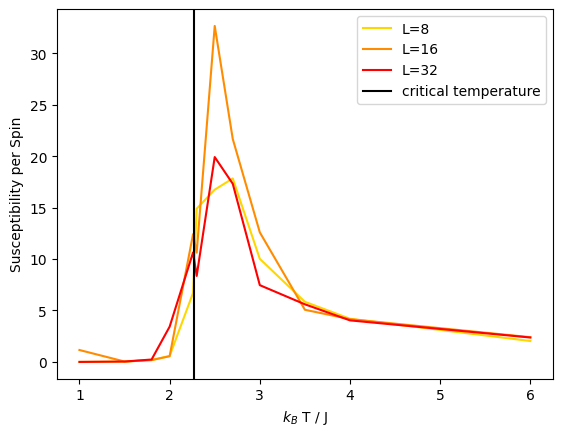

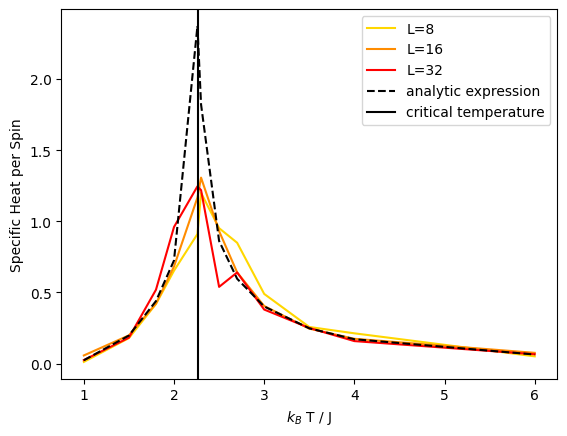

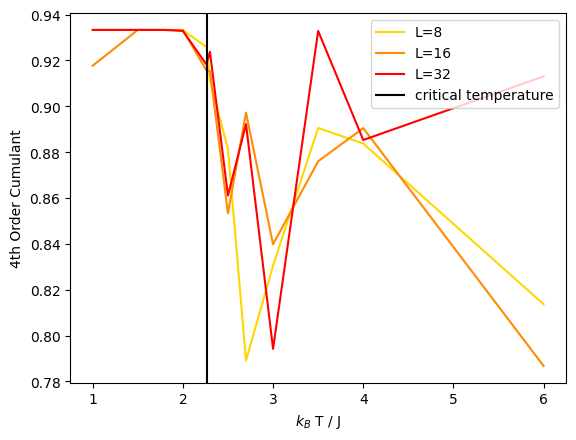

In [ ]:
create_plots_heat_bath(N, T_array, J, k_B, 240, 300, 20, 5)